In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Collection

1. [Dataset is taken from Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews)

2. This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Data includes:

- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

Columns:

1. Id
2. ProductId - Unique identifier for the product
3. UserId - Unqiue identifier for the user
4. ProfileName - Profile name of user
5. HelpfulnessNumerator - Number of users who found the review helpful
6. HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
7. Score - Rating between 1 and 5
8. Time - Timestamp for the review
9. Summary - Brief summary of the review
10. Text - Text of the review


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score, roc_curve

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [56]:
os.listdir()

['.config', 'drive', 'sample_data']

## Reading Data

In [57]:
path = r'/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Amazon Fine Food/Dataset/Reviews.csv'
data = pd.read_csv(path, sep=',')

In [58]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [59]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## 1. Data Cleaning

### 1.1 Filter Review as Positive and Negative

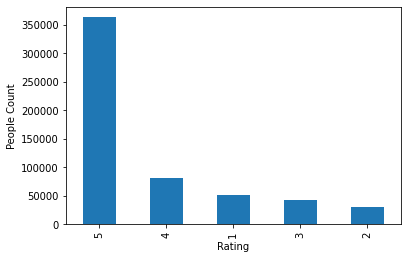

In [61]:
data['Score'].value_counts().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("People Count")
plt.show()

We can see that we have 5-star rating system. We can filter onlt positive and negitive reviews. 

- Review with score>3 : Positive ratings
- Review with score<3 : Negative ratings
- Review with score=3 : Neutral rating (we can skip those ratings)

In [62]:
filtered_data = data[data['Score'] != 3]
filtered_data.loc[data.Score >3,'Score'] = 1    # Positive review
filtered_data.loc[data.Score <3,'Score'] = 0    # Negative review

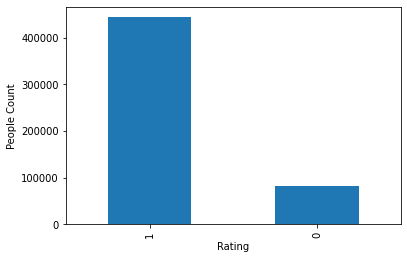

In [63]:
filtered_data['Score'].value_counts().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("People Count")
plt.show()

### 1.2 Checking duplicates
Reviews might contain duplicate entries.  So, we need to remove the duplicate entries so that we get unbiased data for Analysis.

Check duplicate customers with same Summary and Text.

In [64]:
filtered_data.shape

(525814, 10)

In [65]:
# filtered_data.duplicated(subset=["UserId","ProfileName","Time","Summary","Text"]).value_counts()
# filtered_data.duplicated(subset=["Time","Summary","Text"]).value_counts()
filtered_data.duplicated(subset=["UserId", "Summary", "Text", "Time"]).value_counts()

False    365293
True     160521
dtype: int64

As we can see that we have 160678 duplicate customers with same Summary and Text.

Let's remove those customers. Sort the data according to ProductId and keep the first items review and delete the others.

In [66]:
# Sort according to ProductId
sorted_data = filtered_data.sort_values(
    by=["ProductId"], axis=0, ascending=True, inplace=False, kind='mergesort', na_position='last'
)

# drop duplicated data
final = sorted_data.drop_duplicates(subset={"UserId", "Summary", "Text", "Time"}, keep='first', inplace=False)
final.shape

(365293, 10)

`HelpfulnessNumerator` : Number of users who found the review helpful.

`HelpfulnessDenominator` : Number of users who indicated whether they found the review helpful or not.

**HelpfulnessNumerator should be less than HelpfulnessDenominator.**

In [67]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(365291, 10)

In [68]:
# drop the columns
# final.drop(['Id', 'UserId', 'ProductId', 'ProfileName', 'Summary'], axis=1, inplace=True)
final = final[['Text','Score','Time']]

In [69]:
final.head(5)

,Text,Score,Time
150492,"These days, when a person says, ""chicken soup""...",1,1096416000
150493,All of my children love this book. My first g...,1,1173312000
150495,One of my earliest memories is of this book. ...,1,1111363200
150496,I give five stars to the Maurice Sendak story....,0,1334707200
150497,This is a wonderful little book. I loved it 40...,1,1176336000


### 1.3 Checking null values.

In [70]:
final.isna().sum()

Text     0
Score    0
Time     0
dtype: int64

No null values are present

## 2. Preprocessing Review Text

In [73]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)
len(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

**Remove `'no', 'nor', 'not'` from stopwords**

In [74]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", \
             "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", \
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',\
             'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', \
             'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', \
             'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
             'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', \
             'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', \
             'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', \
             'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', \
             'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
             'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', \
             "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
             'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't" \
            ]

### 2.1 Decontractions

Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe.

In [75]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"^cause", "because", phrase)
    
    return phrase

### 2.2 Remove HTML tag, URL, digits, special character

In [76]:
def sentance_clean(sentance):
    # change sentence to lower case
    sentance = sentance.lower()
    # removing URL from sentence
    sentance = re.sub(r"http\S+", "", sentance)
    # removing HTML tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    # removing contraction of words from sentence   # call decontracted funtion for it
    sentance = decontracted(sentance)
    # removing digits
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing special character
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)

    return sentance

### 2.3 Performing the preprocessing steps on all messages

In [77]:
# stemming and lemmatisation object
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [78]:
# Performing the preprocessing steps on all messages

# add stemming and lemmatisation in the preprocess function
def preprocess(document, stem=True):
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(document):
        # call sentance_clean function to clean text
        sentance = sentance_clean(sentance)
        
        # tokenize into words
        words = word_tokenize(sentance)
        # remove stop words
        sentance = [word for word in words if word not in stopwords]
        
        if stem:
            # stemming word
            sentance = [stemmer.stem(word) for word in sentance]
        else:
            # stemming word
            sentance = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in sentance]

        # join words to make sentence
        sentance = " ".join(sentance)

        preprocessed_reviews.append(sentance.strip())
        
    return preprocessed_reviews

In [79]:
final = final.sample(frac=0.80, replace=True, random_state=123)
final.shape

(292233, 3)

In [80]:
# final = final.iloc[:15000]
document = final['Text'].values

In [81]:
%%time
preprocessed_reviews = preprocess(document, stem=True)

100%|██████████| 292233/292233 [07:46<00:00, 625.80it/s]

CPU times: user 7min 40s, sys: 5.19 s, total: 7min 45s
Wall time: 7min 46s


In [82]:
print("Before preprocess\n", document[1])
print("***"*40)
print("After preprocess\n", preprocessed_reviews[1])

Before preprocess
 Used these in some homemade creams. Wow...its an excellent alternative to olive oil too. No smell or greasy feel. Fantastic price for an excellent product.
************************************************************************************************************************
After preprocess
 use homemad cream wow excel altern oliv oil no smell greasi feel fantast price excel product


In [83]:
final['Text'] = preprocessed_reviews

In [84]:
final.head()

,Text,Score,Time
253280,stuff want use want bread food like restaur wo...,1,1349913600
555447,use homemad cream wow excel altern oliv oil no...,1,1325635200
32080,absolut love tast tea everyon els encourag tri...,1,1168992000
544002,order esbilac step supplement puppi feed begin...,1,1350259200
72294,hard find good smokehous bacon one fit bill co...,1,1230336000


## 3. Word Cloud

### 3.1 Word Cloud for positive and negative review

In [85]:
positive_reviews = final[final['Score'] == 1]['Text'].values
negative_reviews = final[final['Score'] == 0]['Text'].values

print("Postive reviews count:",len(positive_reviews))
print("Negative reviews count:",len(negative_reviews))

Postive reviews count: 246246
Negative reviews count: 45987


In [86]:
%%time
positive_reviews = " ".join(word for word in positive_reviews)
negative_reviews = " ".join(word for word in negative_reviews)

positive_reviews_cloud = WordCloud(stopwords=set(STOPWORDS), background_color="black").generate(positive_reviews)
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_reviews)

CPU times: user 46.5 s, sys: 2.38 s, total: 48.9 s
Wall time: 48.9 s


In [87]:
def show_word_cloud(cloud, title):
    plt.figure(figsize = (15, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title, fontsize=25)
    plt.axis("off")
    plt.show()

#### 3.1.1. Positive Word Cloud

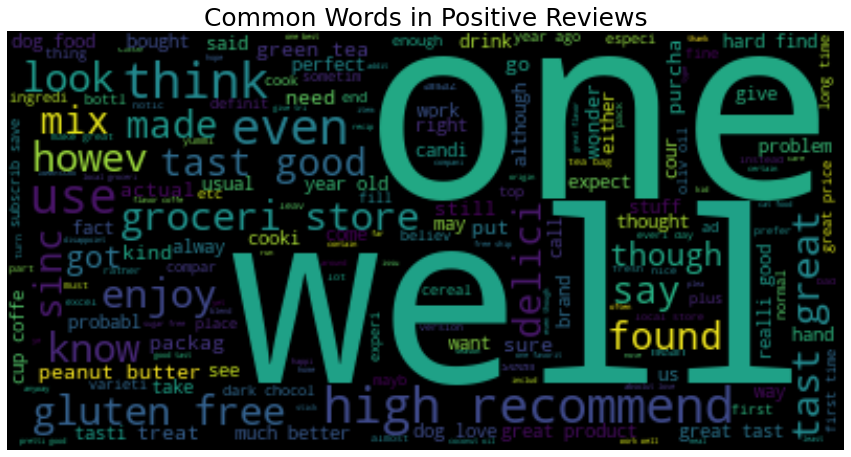

In [88]:
show_word_cloud(positive_reviews_cloud, "Common Words in Positive Reviews")

#### 3.1.2. Negative Word Cloud

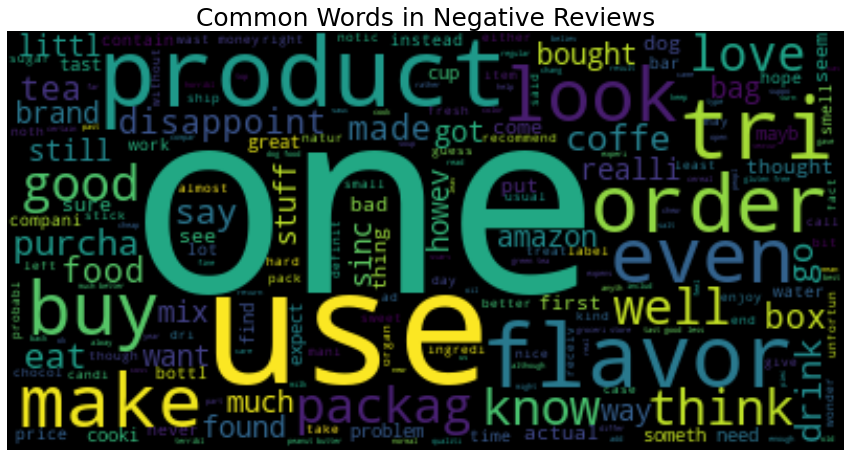

In [89]:
show_word_cloud(negative_reviews_cloud, "Common Words in Negative Reviews")

## Creating a train and test set

In [90]:
X = final[['Text','Time']].sort_values('Time',axis=0).drop('Time',axis=1)

Y = final[['Score','Time']].sort_values('Time',axis=0).drop('Time',axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, Y.Score, test_size=0.20, random_state=123)

In [92]:
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))

X_train size: 233786
X_test size: 58447


## 4. Vectorization

### 4.1 BAG OF WORDS Vectorization

In [93]:
bow_vectorizer = CountVectorizer(min_df=40)

**For Train Data**

In [94]:
# fit data
X_train_bow = bow_vectorizer.fit_transform(X_train.values.astype('U').ravel())

# scale data
X_train_bow = StandardScaler(with_mean=False).fit_transform(X_train_bow)

print(X_train_bow.shape)

(233786, 6610)


**For Test Data**

In [95]:
# fit data
X_test_bow = bow_vectorizer.transform(X_test.values.astype('U').ravel())

# scale data
X_test_bow = StandardScaler(with_mean=False).fit_transform(X_test_bow)

print(X_test_bow.shape)

(58447, 6610)


### 4.2 TFIDF Vectorization

In [96]:
tfidf_vectorizer = TfidfVectorizer(min_df=40)

**For Train Data**

In [97]:
# fit data
X_train_tf = tfidf_vectorizer.fit_transform(X_train.values.astype('U').ravel())

# scale data
X_train_tf = StandardScaler(with_mean=False).fit_transform(X_train_tf)

print(X_train_tf.shape)

(233786, 6610)


**For Test Data**

In [98]:
# fit data
X_test_tf = tfidf_vectorizer.transform(X_test.values.astype('U').ravel())

# scale data
X_test_tf = StandardScaler(with_mean=False).fit_transform(X_test_tf)

print(X_test_tf.shape)

(58447, 6610)


## 5. Model

In [99]:
# defining a class object for model evaluation

class ModelEvaluation:

    def __init__(self, model_instance, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.model_instance = model_instance
        self.y_train_proba = self.model_instance.predict_proba(self.X_train)[:, 1]
        self.y_test_proba = self.model_instance.predict_proba(self.X_test)[:, 1]
        self.y_test_predicted = None
    
    def pred_test(self):
        self.y_train_proba = self.model_instance.predict_proba(self.X_train)[:, 1]
        self.y_test_proba = self.model_instance.predict_proba(self.X_test)[:, 1]
    
    def model_evaluation(self, threshold, params, roc=False):
        '''
        This method is for calculating the evaluation metrics.
        '''
        # params type {'Vectorizer': , 'Hypreparameter':, 'Algorithm':}
        metric = {}
        
        metric['Algorithm'] = params['Algorithm']
        metric['Vectorizer'] = params['Vectorizer']        
        
        # prediction  based on threshhold (probabilty)
        self.y_test_predicted = pd.Series(self.y_test_proba).map(lambda x: 1 if x > threshold else 0)        
        # function call to calculate specificity, sensitivity
        accuracy, specificity, sensitivity = self.calcualte_sensi_speci(self.y_test, self.y_test_predicted)
        
        accuracy_test = round(accuracy_score(self.y_test, self.y_test_predicted), 2)
        print(f"Accuracy = {accuracy_test}")
        metric['Accuracy'] = accuracy_test
        
        auc_test = round(roc_auc_score(self.y_test, self.y_test_proba), 2)
        print(f"AUC = {auc_test}")
        metric['AUC'] = auc_test
        
        print(f"Specificity = {specificity}")
        metric['Specificity'] = specificity
        
        print(f"Sensitivity = {sensitivity}\n")
        metric['Sensitivity'] = sensitivity
        
        metric['Hypreparameter'] = params['Hypreparameter']
        # call function to draw roc
        if roc:
            plt.figure(figsize=(6, 6))
            self.draw_roc()
            plt.show()
        # call function to plot confusion_matrix
        self.plot_confusion_matrix()
        
        return metric
        
    def draw_roc(self):
        '''
        This method plots the ROC curve of the model for the test data
        '''

        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_test_proba,
                                         drop_intermediate = False )
        auc_score = roc_auc_score(self.y_test, self.y_test_proba)
        
        # plt.subplot(1, 2, i)
        plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic for test set')
        plt.legend(loc="lower right")


    @staticmethod
    def calcualte_sensi_speci(y, y_predicted):
        '''
        This calculates the accuracy, specificity and sensitivity
        '''
        confusion = confusion_matrix(y, y_predicted)
        TP = confusion[1,1] # true positive 
        TN = confusion[0,0] # true negatives
        FP = confusion[0,1] # false positives
        FN = confusion[1,0] # false negatives
        
        sensitivity = round(TP / float(TP+FN), 2)
        specificity = round(TN / float(TN+FP), 2)
        accuracy = round((TP+TN)/(TP+TN+FP+FN), 2)
        
        return accuracy, specificity, sensitivity
    
    def senisitivity_specificity_report(self):

        '''
        This method calculates accuracy sensitivity and specificity for various probability cutoffs.
        '''

        cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

        y_train_pred_final = pd.DataFrame({'Score':self.y_train, 'Score_Prob':self.y_train_proba})

        num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

        for i in num:
            y_train_pred_final[i] = y_train_pred_final['Score_Prob'].map(lambda x: 1 if x > i else 0)

        for i in num:
            accuracy, speci, sensi = self.calcualte_sensi_speci(self.y_train, y_train_pred_final[i])
            cutoff_df.loc[i] = [i, accuracy, sensi, speci]

        print(cutoff_df)
        
        return cutoff_df

    @staticmethod
    def sensi_speci_trade_off(df, x, y):
        '''
        This method plots accuracy sensitivity and specificity for various probabilities.
        '''
        
        df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=[8, 6])
        plt.vlines(x=x, ymax=1, ymin=0, colors="r", linestyles="--")
        plt.hlines(y=y, xmax=0.99, xmin=0, colors="g", linestyles="--")
        plt.show()

        print(f'\nOptimal Threshold probability = {x}')
        
        return x

    def plot_confusion_matrix(self):
        '''
        This method plots confusion matrix.
        '''

        y_actual = self.y_test
        y_pred = self.y_test_predicted
        accuracy = accuracy_score(y_actual, y_pred)
        print("Accuracy", "{:2.3}".format(accuracy))

        conf_matrix = confusion_matrix(y_actual, y_pred)

        fig, ax = plt.subplots(figsize=(4, 4))
        ax.matshow(conf_matrix, cmap=plt.cm.Reds, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

        plt.xlabel('Predictions')
        plt.ylabel('Actuals')
        plt.title('Confusion Matrix', fontsize=12)
        plt.show()

    @classmethod
    def metrics_table(self, metrics_dict):
        '''
        Metrics evolution table.
        '''   
        df = []
        for key, value in metrics_dict.items():
            df.append(metrics_dict[key])
        df = pd.DataFrame(df)
        df.set_index('Algorithm', inplace=True)
        return df
    

In [100]:
def lambda_LR1(dict_params):
    # GridSearchCV
    model_lr_final = GridSearchCV(estimator=dict_params['model'], param_grid=dict_params['params'],
                                  cv = 5, scoring='recall', n_jobs = -1, verbose=1)
    # fit cv
    model_lr_final = model_lr_final.fit(dict_params['X_train'], dict_params['y_train'])
    # best_estimator
    best_estimator = model_lr_final.best_estimator_
    best_params = model_lr_final.best_params_
    print("Best parameters", best_params)
    
    return best_estimator, best_params

### 5.1 Logistic Regression with TF-IDF

In [101]:
#  logistic regression object
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)

# parameters for cv
params = {'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1]}
dict_params = {'model':lr_model, 'params': params, 'X_train':X_train_tf, 'y_train':y_train}

In [102]:
%%time
lr_model_tf, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


Best parameters {'C': 0.001, 'penalty': 'l2'}
CPU times: user 4.94 s, sys: 699 ms, total: 5.63 s
Wall time: 3min 37s


In [103]:
# instantiating the class model evaluation
lr_eva_tfidf = ModelEvaluation(lr_model_tf, X_train_tf, X_test_tf, y_train, y_test)

In [104]:
logit_cut_off = lr_eva_tfidf.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.93   0.98   0.62
0.2   0.2      0.93   0.97   0.76
0.3   0.3      0.93   0.95   0.84
0.4   0.4      0.92   0.93   0.89
0.5   0.5      0.91   0.91   0.93
0.6   0.6      0.89   0.87   0.95
0.7   0.7      0.86   0.84   0.97
0.8   0.8      0.81   0.78   0.98
0.9   0.9      0.72   0.67   0.99


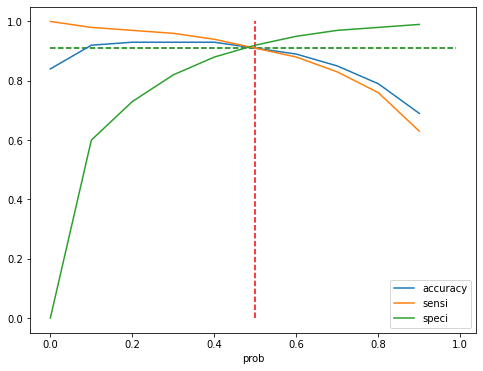


Optimal Threshold probability = 0.5


In [126]:
rf_threshold = lr_eva_tfidf.sensi_speci_trade_off(logit_cut_off, 0.5, 0.91)

Accuracy = 0.9
AUC = 0.96
Specificity = 0.89
Sensitivity = 0.9



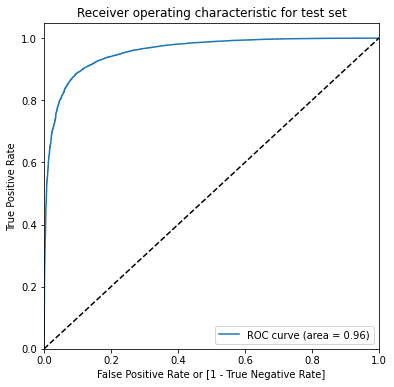

Accuracy 0.897


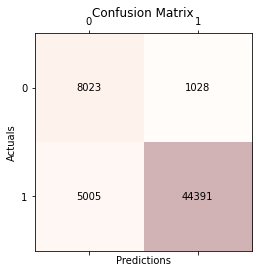

In [127]:
# test data
# calculating the evaluation metrics by calling the method
LR_TF_IDF = {'Vectorizer': 'TF-IDF', 'Hypreparameter':[best_params], 'Algorithm': 'Logistic_Regression_1'}
LR_TF_IDF = lr_eva_tfidf.model_evaluation(rf_threshold, LR_TF_IDF, roc=True)

In [107]:
metrics_dict = {}

In [108]:
metrics_dict['Logistic_Regression_TF_IDF'] = LR_TF_IDF

### 5.2 Logistic Regression with BOW

In [109]:
#  logistic regression object
lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=123)

# parameters for cv
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1]}
dict_params = {'model':lr_model, 'params': params, 'X_train':X_train_bow, 'y_train':y_train}

In [110]:
%%time
lr_model_bow, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


Best parameters {'C': 0.001, 'penalty': 'l2'}
CPU times: user 5.16 s, sys: 203 ms, total: 5.36 s
Wall time: 2min 18s


In [111]:
%%time
# instantiating the class model evaluation
lr_eva_bow = ModelEvaluation(lr_model_bow, X_train_bow, X_test_bow, y_train, y_test)

CPU times: user 34.8 ms, sys: 0 ns, total: 34.8 ms
Wall time: 34.8 ms


In [112]:
logit_cut_off = lr_eva_bow.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.92   0.98   0.60
0.2   0.2      0.93   0.97   0.73
0.3   0.3      0.93   0.96   0.82
0.4   0.4      0.93   0.94   0.88
0.5   0.5      0.91   0.91   0.92
0.6   0.6      0.89   0.88   0.95
0.7   0.7      0.85   0.83   0.97
0.8   0.8      0.79   0.76   0.98
0.9   0.9      0.69   0.63   0.99


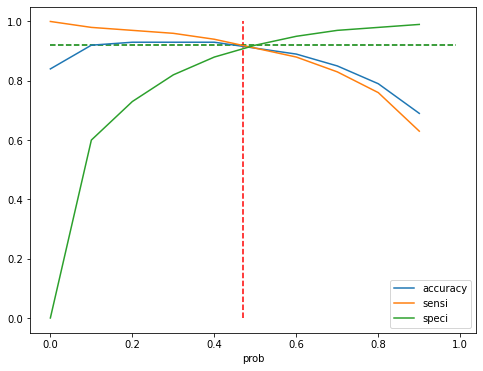


Optimal Threshold probability = 0.47


In [121]:
rf_threshold = lr_eva_bow.sensi_speci_trade_off(logit_cut_off, 0.47, 0.92)

Accuracy = 0.9
AUC = 0.95
Specificity = 0.87
Sensitivity = 0.91



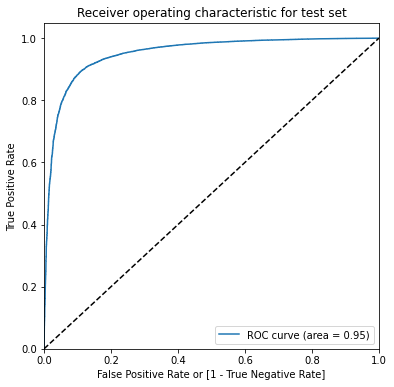

Accuracy 0.905


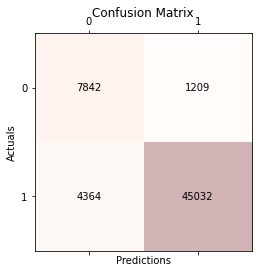

In [122]:
# test data
# calculating the evaluation metrics by calling the method
LR_TF_BOW = {'Vectorizer': 'BOW', 'Hypreparameter':[best_params], 'Algorithm': 'Logistic_Regression_2'}
LR_TF_BOW = lr_eva_bow.model_evaluation(rf_threshold, LR_TF_BOW, roc=True)
metrics_dict['Logistic_Regression_BOW'] = LR_TF_BOW

### 5.3 Naive Bayes with TFIDF

In [128]:
#  naive_bayes object
nv_model = MultinomialNB()
params = {'alpha': (0.00005, 0.00001, 0.0001, 0.001, 0.01, 0.1)}
dict_params = {'model':nv_model, 'params': params, 'X_train':X_train_tf, 'y_train':y_train}

In [129]:
nb_model_tf, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters {'alpha': 5e-05}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


In [130]:
# instantiating the class model evaluation
nb_eva_tfidf = ModelEvaluation(nb_model_tf, X_train_tf, X_test_tf, y_train, y_test)

In [131]:
logit_cut_off = nb_eva_tfidf.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.86   0.87   0.80
0.2   0.2      0.86   0.87   0.80
0.3   0.3      0.86   0.87   0.80
0.4   0.4      0.86   0.87   0.80
0.5   0.5      0.85   0.86   0.81
0.6   0.6      0.85   0.86   0.81
0.7   0.7      0.85   0.86   0.81
0.8   0.8      0.85   0.86   0.81
0.9   0.9      0.85   0.85   0.82


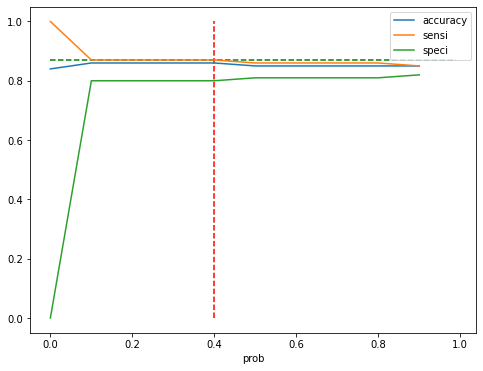


Optimal Threshold probability = 0.4


In [137]:
rf_threshold = nb_eva_tfidf.sensi_speci_trade_off(logit_cut_off, 0.40, 0.87)

Accuracy = 0.85
AUC = 0.88
Specificity = 0.78
Sensitivity = 0.86



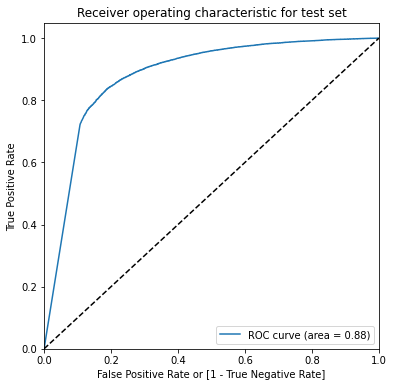

Accuracy 0.848


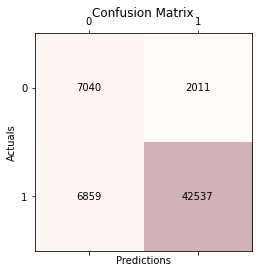

In [138]:
# calculating the evaluation metrics by calling the method
NB_TF_TFIDF = {'Vectorizer': 'TF-IDF', 'Hypreparameter':[best_params], 'Algorithm': 'Naive_Bayes_1'}
NB_TF_TFIDF = nb_eva_tfidf.model_evaluation(rf_threshold, NB_TF_TFIDF, roc=True)

In [139]:
metrics_dict['Naive_Bayes_TF_IDF'] = NB_TF_TFIDF

### 5.4 naive_bayes with BOW

In [153]:
#  naive_bayes object
nv_model = MultinomialNB()

params = {'alpha': (0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 50, 100)}
dict_params = {'model':nv_model, 'params': params, 'X_train':X_train_bow, 'y_train':y_train}

In [154]:
nb_model_bow, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.1s


Best parameters {'alpha': 100}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.6s finished


In [155]:
# instantiating the class model evaluation
nb_eva_bow = ModelEvaluation(nb_model_bow, X_train_bow, X_test_bow, y_train, y_test)

In [156]:
logit_cut_off = nb_eva_bow.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.87   0.89   0.77
0.2   0.2      0.87   0.88   0.78
0.3   0.3      0.86   0.88   0.78
0.4   0.4      0.86   0.88   0.79
0.5   0.5      0.86   0.88   0.79
0.6   0.6      0.86   0.87   0.79
0.7   0.7      0.86   0.87   0.80
0.8   0.8      0.86   0.87   0.80
0.9   0.9      0.85   0.86   0.81


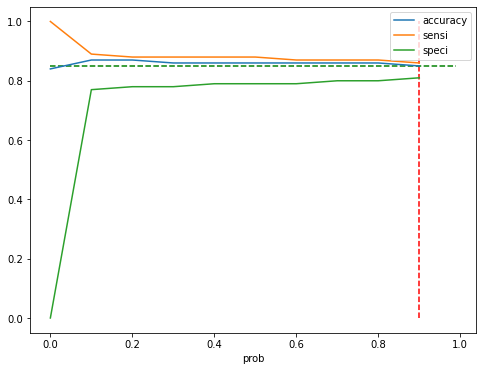


Optimal Threshold probability = 0.9


In [157]:
rf_threshold = nb_eva_bow.sensi_speci_trade_off(logit_cut_off, 0.9, 0.85)

Accuracy = 0.85
AUC = 0.88
Specificity = 0.79
Sensitivity = 0.86



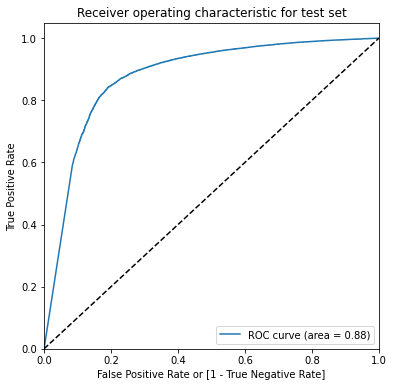

Accuracy 0.846


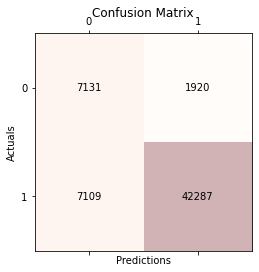

In [158]:
# calculating the evaluation metrics by calling the method
NB_TF_BOW = {'Vectorizer': 'BOW', 'Hypreparameter':[best_params], 'Algorithm': 'Naive_Bayes_2'}
NB_TF_BOW = nb_eva_bow.model_evaluation(rf_threshold, NB_TF_BOW, roc=True)
metrics_dict['Naive_Bayes_BOW'] = NB_TF_BOW

### 5.5 Random Forest with TFIDF

In [159]:
from sklearn.ensemble import RandomForestClassifier

In [160]:
# random forest object
rf_model = RandomForestClassifier(class_weight='balanced', random_state=123)
params = {
    'max_depth': [6,9,12],
}
dict_params = {'model':rf_model, 'params': params, 'X_train':X_train_tf, 'y_train':y_train}

In [161]:
rf_model_tf, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.5min finished


Best parameters {'max_depth': 12}


In [162]:
# instantiating the class model evaluation
rf_eva_tfidf = ModelEvaluation(rf_model_tf, X_train_tf, X_test_tf, y_train, y_test)

In [163]:
logit_cut_off = rf_eva_tfidf.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.84   1.00   0.00
0.2   0.2      0.84   1.00   0.00
0.3   0.3      0.84   1.00   0.02
0.4   0.4      0.88   1.00   0.23
0.5   0.5      0.86   0.87   0.82
0.6   0.6      0.35   0.22   1.00
0.7   0.7      0.16   0.00   1.00
0.8   0.8      0.16   0.00   1.00
0.9   0.9      0.16   0.00   1.00


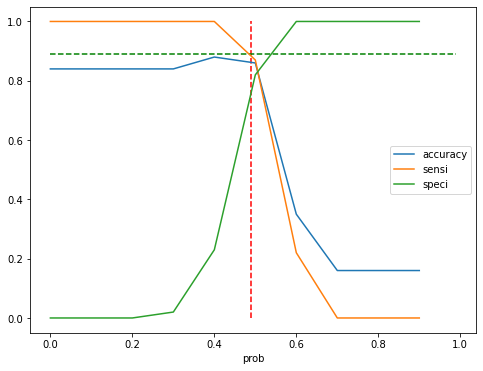


Optimal Threshold probability = 0.49


In [166]:
rf_threshold = rf_eva_tfidf.sensi_speci_trade_off(logit_cut_off, 0.49, 0.89)

Accuracy = 0.87
AUC = 0.91
Specificity = 0.74
Sensitivity = 0.9



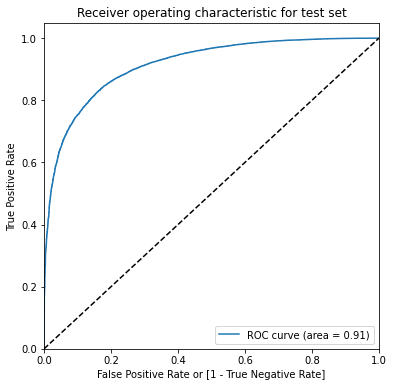

Accuracy 0.873


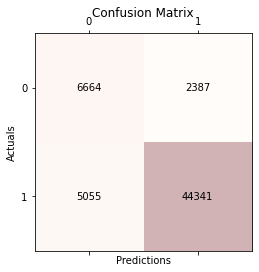

In [167]:
# calculating the evaluation metrics by calling the method
RF_TF_TFIDF = {'Vectorizer': 'TF-IDF', 'Hypreparameter':[best_params], 'Algorithm': 'Random_Forest_1'}
RF_TF_TFIDF = rf_eva_tfidf.model_evaluation(rf_threshold, RF_TF_TFIDF, roc=True)

In [168]:
metrics_dict['Random_Forest_TF_IDF'] = RF_TF_TFIDF

### 5.5 Random Forest with BOW

In [170]:
from sklearn.ensemble import RandomForestClassifier

In [171]:
# random forest object
rf_model = RandomForestClassifier(class_weight='balanced', random_state=123)
params = {
    'max_depth': [16, 20],
    'n_estimators': [50, 200],
}
dict_params = {'model':rf_model, 'params': params, 'X_train':X_train_bow, 'y_train':y_train}

In [172]:
rf_model_bow, best_params = lambda_LR1(dict_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.5min finished


Best parameters {'max_depth': 20, 'n_estimators': 200}


In [173]:
# instantiating the class model evaluation
rf_eva_bow = ModelEvaluation(rf_model_bow, X_train_bow, X_test_bow, y_train, y_test)

In [174]:
logit_cut_off = rf_eva_bow.senisitivity_specificity_report()

     prob  accuracy  sensi  speci
0.0   0.0      0.84   1.00   0.00
0.1   0.1      0.84   1.00   0.00
0.2   0.2      0.84   1.00   0.01
0.3   0.3      0.86   1.00   0.13
0.4   0.4      0.91   1.00   0.46
0.5   0.5      0.90   0.92   0.85
0.6   0.6      0.62   0.55   0.99
0.7   0.7      0.23   0.09   1.00
0.8   0.8      0.16   0.00   1.00
0.9   0.9      0.16   0.00   1.00


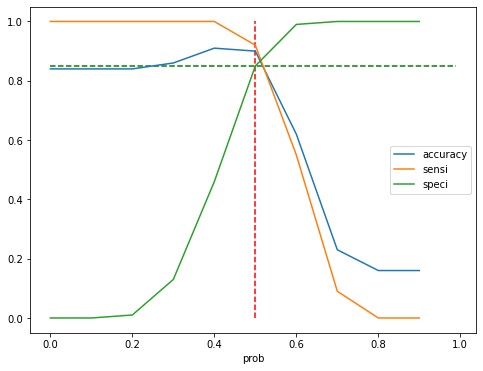


Optimal Threshold probability = 0.5


In [179]:
rf_threshold = rf_eva_bow.sensi_speci_trade_off(logit_cut_off, 0.50, 0.85)

Accuracy = 0.89
AUC = 0.94
Specificity = 0.8
Sensitivity = 0.9



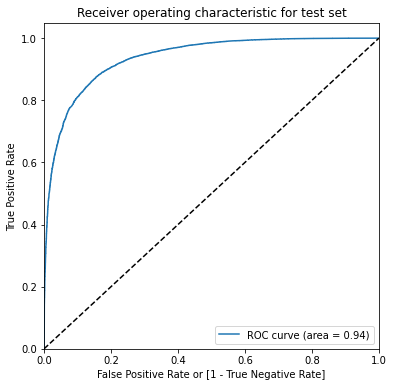

Accuracy 0.888


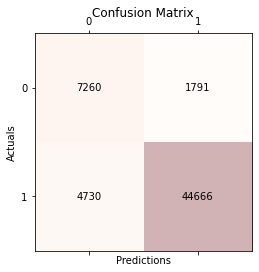

In [180]:
# calculating the evaluation metrics by calling the method
RF_TF_BOW = {'Vectorizer': 'BOW', 'Hypreparameter':[best_params], 'Algorithm': 'Random_Forest_2'}
RF_TF_BOW = rf_eva_bow.model_evaluation(rf_threshold, RF_TF_BOW, roc=True)

In [181]:
metrics_dict['Random_Forest_BOW'] = RF_TF_BOW

## Evolution Metrics

In [182]:
metrics_table = ModelEvaluation.metrics_table(metrics_dict)
metrics_table

,Vectorizer,Accuracy,AUC,Specificity,Sensitivity,Hypreparameter
Algorithm,,,,,,
Logistic_Regression_1,TF-IDF,0.91,0.96,0.84,0.93,"[{'C': 0.001, 'penalty': 'l2'}]"
Logistic_Regression_2,BOW,0.90,0.95,0.87,0.91,"[{'C': 0.001, 'penalty': 'l2'}]"
Naive_Bayes_1,TF-IDF,0.85,0.88,0.78,0.86,[{'alpha': 5e-05}]
Naive_Bayes_2,BOW,0.85,0.88,0.79,0.86,[{'alpha': 100}]
Random_Forest_1,TF-IDF,0.87,0.91,0.74,0.90,[{'max_depth': 12}]
Random_Forest_2,BOW,0.89,0.94,0.80,0.90,"[{'max_depth': 20, 'n_estimators': 200}]"


## Conclusion:
- Logistic regression with TF-IDF and BOW model are giving  more accurate result.
- Also Random Forest with BOW model is giving better result as compare to Naive Bayes.


In [183]:
metrics_dict

{'Logistic_Regression_BOW': {'AUC': 0.95,
  'Accuracy': 0.9,
  'Algorithm': 'Logistic_Regression_2',
  'Hypreparameter': [{'C': 0.001, 'penalty': 'l2'}],
  'Sensitivity': 0.91,
  'Specificity': 0.87,
  'Vectorizer': 'BOW'},
 'Logistic_Regression_TF_IDF': {'AUC': 0.96,
  'Accuracy': 0.91,
  'Algorithm': 'Logistic_Regression_1',
  'Hypreparameter': [{'C': 0.001, 'penalty': 'l2'}],
  'Sensitivity': 0.93,
  'Specificity': 0.84,
  'Vectorizer': 'TF-IDF'},
 'Naive_Bayes_BOW': {'AUC': 0.88,
  'Accuracy': 0.85,
  'Algorithm': 'Naive_Bayes_2',
  'Hypreparameter': [{'alpha': 100}],
  'Sensitivity': 0.86,
  'Specificity': 0.79,
  'Vectorizer': 'BOW'},
 'Naive_Bayes_TF_IDF': {'AUC': 0.88,
  'Accuracy': 0.85,
  'Algorithm': 'Naive_Bayes_1',
  'Hypreparameter': [{'alpha': 5e-05}],
  'Sensitivity': 0.86,
  'Specificity': 0.78,
  'Vectorizer': 'TF-IDF'},
 'Random_Forest_BOW': {'AUC': 0.94,
  'Accuracy': 0.89,
  'Algorithm': 'Random_Forest_2',
  'Hypreparameter': [{'max_depth': 20, 'n_estimators': 200}